In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
from sympy import Symbol
import centrex_TlF as centrex
import matplotlib.pyplot as plt
import sys
sys.path.append("../..")
from utils.plot_utils import set_fontsize

In [2]:
nprocs_python = 6 # processes for python
nprocs_julia = 7 # processes for julia

# Γ
Γ = 1.56e6*2*np.pi

# TlF temperature
T = 6.3

# Define all involved states

# ground state J levels
ground_Js = [0,1,2,3]

# excited state quantum numbers
excited_Js = [1]
excited_F1s = [3/2]
excited_Fs = [1]
excited_Ps = [-1]

# Settings for transitions

# min and max J level to look for mixing in the B state
excited_Jmin = 1
excited_Jmax = 2


# main laser transition P(2) F'=1 F1'=3/2

ground_main_approx = 1*centrex.CoupledBasisState(J=2,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,
                                                 electronic_state='X', P = (-1)**2, Omega = 0)
excited_main_approx = 1*centrex.CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, 
                                                  electronic_state='B', P = -1, Omega = 1)
# ground laser J
laser_J = [2]

transitions = [{'ground main approx': ground_main_approx, 
                'excited main approx': excited_main_approx,
                'ground states approx': 1*centrex.states.generate_coupled_states_ground(laser_J),
                'excited states approx': 1*centrex.states.generate_coupled_states_excited(
                                                excited_Js, excited_Fs, excited_F1s, excited_Ps),
                'main polarization': np.array([0,0,1]),
                'polarizations': [np.array([0,0,1]), np.array([1,0,0])],
                'polarization symbols': [Symbol("Plz"), Symbol("Plx")],
                'Ω symbol': Symbol('Ωl', complex = True),
                'Δ symbol': Symbol('δl'),
                'description': "P2 F1 laser transition"
               }]
               
# make sure that subsequent transitions don't have their excited state be the ground state of another transition
transitions.append(
    {
        'ground main approx': 1*centrex.CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**2, Omega = 0),
        'excited main approx': 1*centrex.CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0),
        'ground states approx': 1*centrex.states.generate_coupled_states_ground([2]),
        'excited states approx': 1*centrex.states.generate_coupled_states_ground([1]),
        'main polarization': np.array([0,0,1]),
        'polarizations': [np.array([0,0,1]), np.array([0,1,0])],
        'polarization symbols': [Symbol("Pμ12z"), Symbol("Pμ12y")],
        'Ω symbol': Symbol('Ωμ12', complex = True),
        'Δ symbol': Symbol('δμ12'),
        'description': "J12 microwave transition"
    }
)

transitions.append(
    {
        'ground main approx': 1*centrex.CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**2, Omega = 0),
        'excited main approx': 1*centrex.CoupledBasisState(J=3,F1=5/2,F=3,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0),
        'ground states approx': 1*centrex.states.generate_coupled_states_ground([2]),
        'excited states approx': 1*centrex.states.generate_coupled_states_ground([3]),
        'main polarization': np.array([0,0,1]),
        'polarizations': [np.array([0,0,1]), np.array([0,1,0])],
        'polarization symbols': [Symbol("Pμ23z"), Symbol("Pμ23y")],
        'Ω symbol': Symbol('Ωμ23', complex = True),
        'Δ symbol': Symbol('δμ23'),
        'description': "J23 microwave transition"
    }
)

# sanity check to ensure no ground states for one transition are an
# excited state for another transition
centrex.couplings.utils.check_transitions(transitions)

In [3]:
# specify states to combine into a single level 
# e.g. only decay to these states and not interested in population distribution there
slice_compact = None

### Specifying parameters and the ode function preamble
Allows for setting parameters to be time dependent (e.g. sin(t), cos(t))

In [4]:
# order of parameters in p
parameters = ['Ωl', 'δl', 'ωlp', 'ϕlp', 'Ωμ12', 'δμ12', 'ωμ12p', 'ϕμ12p', 'Ωμ23', 'δμ23', 'ωμ23p', 'ϕμ23p']

In [5]:
preamble = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tδl = p[2]
\t\tωlp = p[3]
\t\tϕlp = p[4]
\t\tΩlᶜ = conj(Ωl)

\t\tPl = sin(ωlp*t + ϕlp)
\t\tPlx = (1-Pl)/2
\t\tPlz = (1+Pl)/2

\t\tΩμ12 = p[5]
\t\tδμ12 = p[6]
\t\tωμ12p = p[7]
\t\tϕμ12p = p[8]
\t\tΩμ12ᶜ = conj(Ωμ12)

\t\tPμ12 = sin(ωμ12p*t + ϕμ12p)
\t\tPμ12y = (1-Pμ12)/2
\t\tPμ12z = (1+Pμ12)/2

\t\tΩμ23 = p[9]
\t\tδμ23 = p[10]
\t\tωμ23p = p[11]
\t\tϕμ23p = p[12]
\t\tΩμ23ᶜ = conj(Ωμ23)

\t\tPμ23 = sin(ωμ23p*t + ϕμ23p)
\t\tPμ23y = (1-Pμ23)/2
\t\tPμ23z = (1+Pμ23)/2

"""

In [6]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = Γ
odepars.ωlp = 0
odepars.Ωμ12 = 3*Γ
odepars.ωμ12p = 2*np.pi*1e6
# unicode string ϕ is different from jupyter notebook ϕ
# have to use setattr, have to find a better way to do this
setattr(odepars, 'ϕμ12p', 0)
odepars.Ωμ23 = 0.5*Γ
odepars.ωμ23p = 2*np.pi*1e6
setattr(odepars, 'ϕμ23p', np.pi)
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, ωlp: 0.00e+00, ϕlp: 0.00e+00, Ωμ12: 2.94e+07, δμ12: 0.00e+00, ωμ12p: 6.28e+06, ϕμ12p: 0.00e+00, Ωμ23: 4.90e+06, δμ23: 0.00e+00, ωμ23p: 6.28e+06, ϕμ23p: 3.14e+00)

In [7]:
odepars.to_units_Γ(Γ)

'odeParameters(Ωl: 1.00, δl: 0.00, ωlp: 0.00, ϕlp: 0.00, Ωμ12: 3.00, δμ12: 0.00, ωμ12p: 0.64, ϕμ12p: 0.00, Ωμ23: 0.50, δμ23: 0.00, ωμ23p: 0.64, ϕμ23p: 3.14)'

## Start calculations for Hamiltonian and transitions

In [15]:
%%time 
ground_states_approx = centrex.states.generate_coupled_states_ground(ground_Js)
excited_states_approx = centrex.states.generate_coupled_states_excited(excited_Js, excited_Fs, 
                                                                       excited_F1s, excited_Ps)

ground_states, excited_states, QN, H_int, V_ref_int = centrex.hamiltonian.generate_total_reduced_hamiltonian(
                                            ground_states_approx, excited_states_approx,
                                            Jmin = excited_Jmin, Jmax = excited_Jmax)

Wall time: 10.9 s


In [16]:
%%time
couplings = []
for transition in transitions:
    coupling = centrex.couplings.generate_coupling_field(
                                        transition['ground main approx'],
                                        transition['excited main approx'],
                                        transition['ground states approx'],
                                        transition['excited states approx'],
                                        H_int, QN, V_ref_int, 
                                        pol_main = transition['main polarization'],
                                        pol_vec = transition['polarizations'],
                                        nprocs = nprocs_python)
    couplings.append(coupling)

Wall time: 7min 12s


In [17]:
%%time
H_symbolic = centrex.lindblad.generate_total_symbolic_hamiltonian(QN, H_int, couplings, transitions, 
                                                                slice_compact = slice_compact)

Wall time: 2.35 s


In [18]:
%%time
C_array = centrex.couplings.collapse_matrices(QN, ground_states, excited_states, gamma = Γ, 
                                            slice_compact = slice_compact)
system = centrex.lindblad.generate_system_of_equations_symbolic(H_symbolic, C_array, progress = False, fast = True)

Wall time: 1min 45s


In [19]:
%%time
# convert matrix to system of equations code
code_lines = centrex.lindblad.system_of_equations_to_lines(system, nprocs = nprocs_python)

Wall time: 2min 40s


In [20]:
couplings[0].keys()

dict_keys(['ground main', 'excited main', 'main coupling', 'ground_states', 'excited states', 'D', 'fields'])

In [21]:
print("Transitions in model")
for coupling in couplings:
    main_coupling = coupling['main coupling']
    g = coupling['ground main'].find_largest_component()
    e = coupling['excited main'].find_largest_component()
    msg = f"|{g.electronic_state}, J={g.J}> -> |{e.electronic_state}, J={e.J}> : {np.abs(main_coupling):.2f}"
    msg += " main transition amp"
    print(msg)

Transitions in model
|X, J=2> -> |B, J=1> : 0.10 main transition amp
|X, J=2> -> |X, J=1> : 0.49 main transition amp
|X, J=2> -> |X, J=3> : 0.04 main transition amp


In [22]:
odepars.Ωl = centrex.utils.calculate_rabi_from_power_gaussian_beam(80e-3, 0.1, 1e-3, 5e-3)
odepars.Ωμ12 = centrex.utils.calculate_rabi_from_power_gaussian_beam_microwave(200e-3, 0.49, 1e-2, 1e-2)
odepars.Ωμ23 = centrex.utils.calculate_rabi_from_power_gaussian_beam_microwave(200e-3, 0.04, 1e-2, 1e-2)
print(odepars.to_units_Γ(Γ))

odeParameters(Ωl: 0.36, δl: 0.00, ωlp: 0.00, ϕlp: 0.00, Ωμ12: 3.27, δμ12: 0.00, ωμ12p: 0.64, ϕμ12p: 0.00, Ωμ23: 0.27, δμ23: 0.00, ωμ23p: 0.64, ϕμ23p: 3.14)


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [23]:
# import julia
# julia.install()

In [24]:
from julia import Main
centrex.lindblad.initialize_julia(nprocs = nprocs_julia)

_ = centrex.lindblad.generate_ode_fun_julia(preamble, code_lines)

# generate initial conditions
ρ_ini = centrex.utils.generate_thermal_J(ground_Js, len(excited_states), T, normalized = True)
centrex.lindblad.setup_variables_julia(Γ, ρ_ini)
odepars.generate_p_julia()

Initialized Julia with 7 processes


### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [25]:
# precompile function
du = np.zeros(H_symbolic.shape, dtype = complex)
Main.du = du
Main.eval("@time Lindblad_rhs!(du, ρ, p, 0.1)")

In [26]:
odepars.generate_p_julia()
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [27]:
indices_diag = [str(i) for i in centrex.lindblad.get_indices_diag_flattened(len(H_int))+1]

In [28]:
%%time
Main.eval(f"""
@time sol = solve(prob, Tsit5(), abstol = 2.5e-7, reltol = 2.5e-4, progress = true, saveat = 1e-7, save_idxs = [{','.join(indices_diag)}]);
tmp = 0
""");

Wall time: 31.1 s


0

In [29]:
pop_results = np.array(Main.eval("sol[:]")).T.real
t_array = Main.eval("sol.t")

In [30]:
#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

J=0 ratio : 10.55


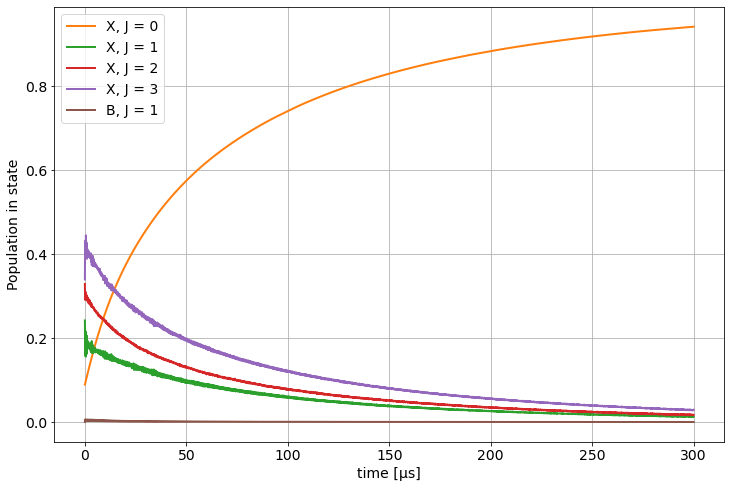

In [31]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0', lw = 2, color = 'C1')
ax.plot(t_array*1e6, P1, label = 'X, J = 1', lw = 2, color = 'C2')
ax.plot(t_array*1e6, P2, label = 'X, J = 2', lw = 2, color = 'C3')
ax.plot(t_array*1e6, P3, label = 'X, J = 3', lw = 2, color = 'C4')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1', lw = 2, color = 'C5')

ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]', fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

print(f'J=0 ratio : {P0[-1]/np.diag(ρ_ini)[:4].sum().real:.2f}')

In [33]:
pop_results[0,-1]/pop_results[0,0]

27.573832887647605

## Scan Polarization switching frequency

In [25]:
print(odepars.to_units_Γ(Γ))

odeParameters(Ωl: 0.36, δl: 0.00, ωlp: 0.00, ϕlp: 0.00, Ωμ12: 3.27, δμ12: 0.00, ωμ12p: 0.64, ϕμ12p: 0.00, Ωμ23: 0.27, δμ23: 0.00, ωμ23p: 0.64, ϕμ23p: 3.14)


In [26]:
odepars.generate_p_julia()
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [27]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, ['ωμ12p', 'ωμ23p'], np.linspace(0,1*Γ,101))

In [28]:
# generate the output_func to transform the ode solution after integration
centrex.lindblad.setup_ratio_calculation([[1],[2,3,4]])

In [29]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [30]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-7, reltol = 1e-4, save_everystep = false)
sim.elapsedTime
""")

3227.2029963

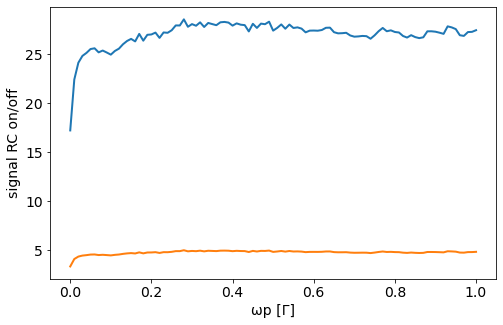

In [31]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)[0], lw = 2)
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)[1], lw = 2)

ax.set_xlabel('ωp [Γ]')
ax.set_ylabel('signal RC on/off')

set_fontsize(ax, 14)

In [32]:
np.max(np.array(Main.sim)[0])

28.534980635646665

In [33]:
pF0 = np.diag(ρ_ini)[0].real
pF1 = np.diag(ρ_ini)[1:4].real.sum()

rJ12_F0 = 0.337/(0.147+0.337) * np.diag(ρ_ini)[4:].sum().real
rJ12_F1 = 0.147/0.337 * rJ12_F0

gF0 = (pF0 + rJ12_F0)/pF0
gF1 = (pF1 + rJ12_F1)/pF1

print(f"max gain in J = 0, F = 0 : {(gF0):.2f}")
print(f"max gain in J = 0, F = 1 : {(gF1):.2f}")

max gain in J = 0, F = 0 : 29.41
max gain in J = 0, F = 1 : 5.13


## Scan Ωl and Ωμ12

In [44]:
print(odepars.to_units_Γ(Γ))

odeParameters(Ωl: 0.36, δl: 0.00, ωlp: 0.00, ϕlp: 0.00, Ωμ12: 3.27, δμ12: 0.00, ωμ12p: 0.64, ϕμ12p: 0.00, Ωμ23: 0.27, δμ23: 0.00, ωμ23p: 0.64, ϕμ23p: 3.14)


In [45]:
odepars.generate_p_julia()
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [46]:
Ωls = centrex.utils.calculate_rabi_from_power_gaussian_beam(np.linspace(0,500e-3,15), 0.1, 1e-3, 5e-3)
Ωμs = centrex.utils.calculate_rabi_from_power_gaussian_beam_microwave(np.linspace(0,250e-3,15), 0.49, 1e-2, 1e-2)
# generate the prob_func to remake the problem for each iteration
ind_random = centrex.lindblad.setup_parameter_scan_ND(odepars, ['Ωl', 'Ωμ12'], [Ωls, Ωμs], randomize = True)

In [47]:
# generate the output_func to transform the ode solution after integration
centrex.lindblad.setup_ratio_calculation([[1],[2,3,4]])

In [48]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [49]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-7, reltol = 1e-4, save_everystep = false)
sim.elapsedTime
""")

1995.3031745

In [53]:
params,result = centrex.lindblad.handle_randomized_ensemble_solution(ind_random)

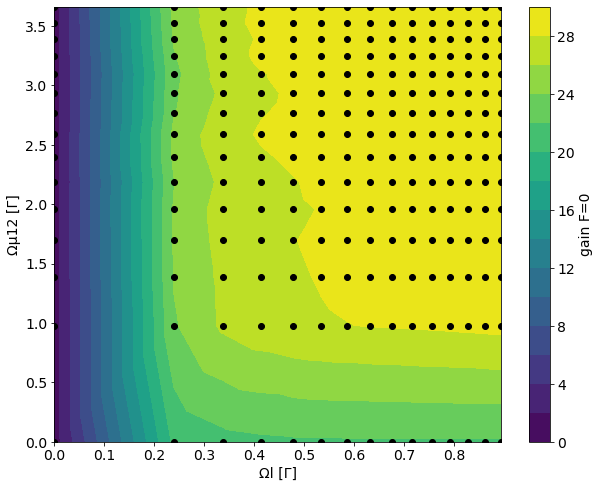

In [56]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]/Γ, params[:,1]/Γ, result[:,0], levels = 15)
ax.scatter(params[:,0]/Γ, params[:,1]/Γ, color = 'k')

cbar = fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ12 [Γ]')
cbar.ax.set_ylabel('gain F=0')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [57]:
lpower = centrex.utils.calculate_power_from_rabi_gaussian_beam(params[:,0], 0.1, 1e-3, 5e-3)
μpower = centrex.utils.calculate_power_from_rabi_gaussian_beam_microwave(params[:,1], 0.49, 1e-2, 1e-2)

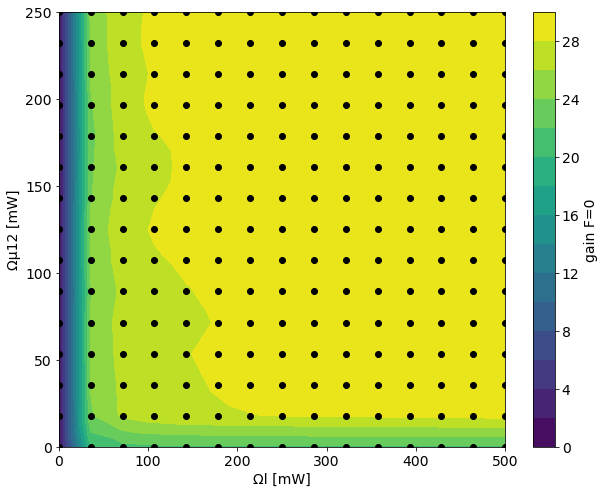

In [62]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(lpower*1e3, μpower*1e3, result[:,0], levels = 15)

cbar = fig.colorbar(tcf)
ax.scatter(lpower*1e3, μpower*1e3, color = 'k')

ax.set_xlabel('Ωl [mW]')
ax.set_ylabel(r'Ωμ12 [mW]')
cbar.ax.set_ylabel('gain F=0')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Scan Ωl and Ωμ12

In [34]:
print(odepars.to_units_Γ(Γ))

odeParameters(Ωl: 0.36, δl: 0.00, ωlp: 0.00, ϕlp: 0.00, Ωμ12: 3.27, δμ12: 0.00, ωμ12p: 0.64, ϕμ12p: 0.00, Ωμ23: 0.27, δμ23: 0.00, ωμ23p: 0.64, ϕμ23p: 3.14)


In [35]:
odepars.generate_p_julia()
Main.eval("""
tspan = (0.0, 210e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [36]:
Ωls = centrex.utils.calculate_rabi_from_power_gaussian_beam(np.linspace(0,500e-3,15), 0.1, 1e-3, 5e-3)
Ωμs = centrex.utils.calculate_rabi_from_power_gaussian_beam_microwave(np.linspace(0,250e-3,15), 0.49, 1e-2, 1e-2)
# generate the prob_func to remake the problem for each iteration
ind_random = centrex.lindblad.setup_parameter_scan_ND(odepars, ['Ωl', 'Ωμ12'], [Ωls, Ωμs], randomize = True)

In [37]:
# generate the output_func to transform the ode solution after integration
centrex.lindblad.setup_ratio_calculation([[1],[2,3,4]])

In [38]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [39]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-7, reltol = 1e-4, save_everystep = false)
sim.elapsedTime
""")

3768.0223477

In [40]:
params,result = centrex.lindblad.handle_randomized_ensemble_solution(ind_random)

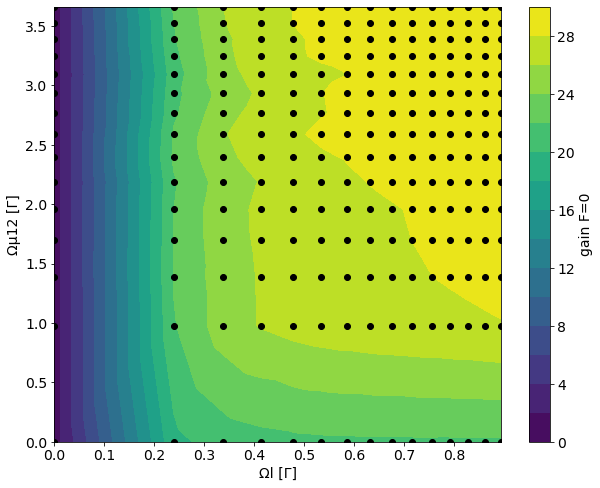

In [41]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]/Γ, params[:,1]/Γ, result[:,0], levels = 15)
ax.scatter(params[:,0]/Γ, params[:,1]/Γ, color = 'k')

cbar = fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ12 [Γ]')
cbar.ax.set_ylabel('gain F=0')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [42]:
lpower = centrex.utils.calculate_power_from_rabi_gaussian_beam(params[:,0], 0.1, 1e-3, 5e-3)
μpower = centrex.utils.calculate_power_from_rabi_gaussian_beam_microwave(params[:,1], 0.49, 1e-2, 1e-2)

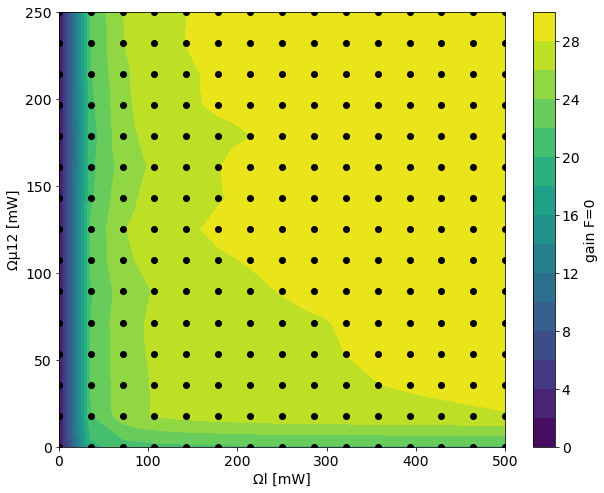

In [43]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(lpower*1e3, μpower*1e3, result[:,0], levels = 15)

cbar = fig.colorbar(tcf)
ax.scatter(lpower*1e3, μpower*1e3, color = 'k')

ax.set_xlabel('Ωl [mW]')
ax.set_ylabel(r'Ωμ12 [mW]')
cbar.ax.set_ylabel('gain F=0')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

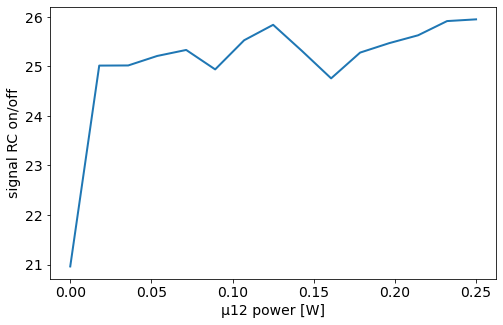

In [57]:
m = np.isclose(lpower, 0.07142857)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(μpower[m], result[:,0][m], lw = 2)

ax.set_xlabel('μ12 power [W]')
ax.set_ylabel('signal RC on/off')

set_fontsize(ax, 14)